In [217]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import re
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')


In [218]:


data = pd.read_csv(
    r"orders.csv",sep=";", encoding='latin-1')

data['DataInserido'] = data['DataInserido'].apply(lambda k: str(k).split()[0])
data['DataInserido'] = pd.to_datetime(data['DataInserido'])

data.dropna()

data = data.drop_duplicates()
data.head(3)
new_data = data.set_index('DataInserido')

In [219]:

status = ['Em Trânsito','Entregue','Em transferência','NF Emitida','Pago','Em separação']

new_data = data[data['StatusPedido'].isin(status)]

new_data.head(4)


,IdPedidoItensFlexy,CodigoPedido,Marca,PrazoFabricacao,StatusPedido,NomeProduto,EAN,PrecoFrete,IdColaborador,IdFormaPagamento,...,PrecoUnitario,SKU,DescontoItem,Desconto,IdUnidade,PrecoUnitarioDescontado,DataInserido,ValorTotal,IdCliente,IdProduto
30,1009,4623,Elizabeth,90,Entregue,Porcelanato Urban Off-White Esmaltado 84x84cm ...,7899060687916,110.0,702,41.0,...,78.24,1040001002937,9.78,9.780.000.000,63,70.59,2021-10-06,1824.56,2033,19024
36,1020,4636,Deca Louças,120,Entregue,Assento Plástico Izy/Izy Conforto/Ravena Branc...,7894200757795,110.0,657,40.0,...,59.88,AP.01.17,14.48,14.483.000.000,39,51.21,2021-10-06,3179.04,2053,2912
37,1021,4636,Deca Louças,120,Entregue,Cuba De Embutir Oval Branca Deca,7894200763802,110.0,657,40.0,...,103.32,L.59.17,14.48,14.483.000.000,39,88.36,2021-10-06,3179.04,2053,3395
38,1018,4636,Deca Louças,120,Entregue,Bacia Para Caixa Acoplada Izy Conforto Branca ...,7894200740612,110.0,657,40.0,...,529.84,P.115.17,14.48,14.483.000.000,39,453.12,2021-10-06,3179.04,2053,3531


In [220]:
new_data.columns
new_data.sort_index(inplace=True)

<AxesSubplot: xlabel='DataInserido'>

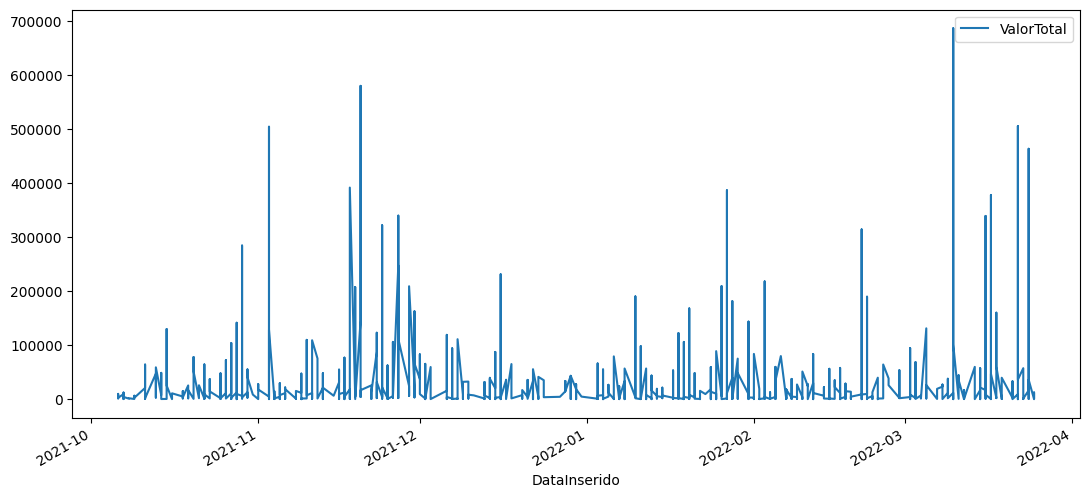

In [221]:
new_data.sort_index(inplace=True)

venda_marca_mes = new_data.groupby(['DataInserido','Marca'])['ValorTotal'].sum().reset_index()

venda_marca_mes = venda_marca_mes.set_index('DataInserido')

venda_marca_mes.plot(figsize=(13,6))

In [222]:
#Aplicando Modelo Série Temporam - Modelo ARIMA

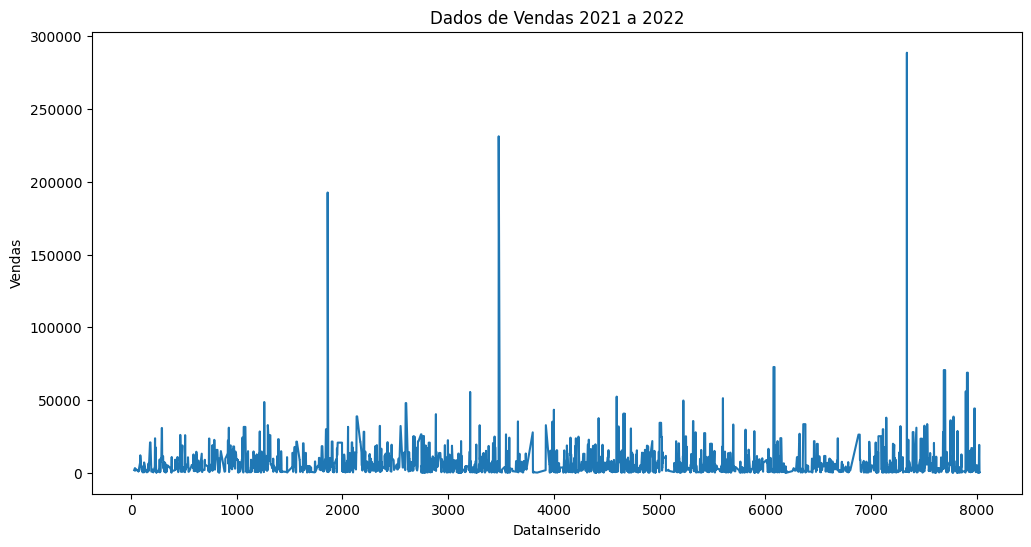

In [223]:
ax = new_data['ValorTotal'].plot(figsize = (12,6)) 
ax.autoscale(axis = 'both ',tight = True) 
ax.set(ylabel='Vendas'
,xlabel="DataInserido",title='Dados de Vendas 2021 a 2022');

In [224]:
"""
Vendas se mantem estaveis durante os meses do ano exceto entre 11 e 12 de 2021 que aparentemente tem um aumento
E jan de 2022 e entre 03 e 04 de 2022
"""

'\nVendas se mantem estaveis durante os meses do ano exceto entre 11 e 12 de 2021 que aparentemente tem um aumento\nE jan de 2022 e entre 03 e 04 de 2022\n'

In [225]:
#Tendencia Sazonal

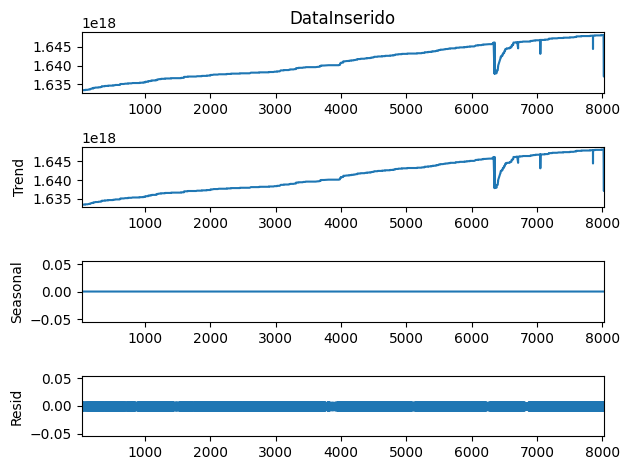

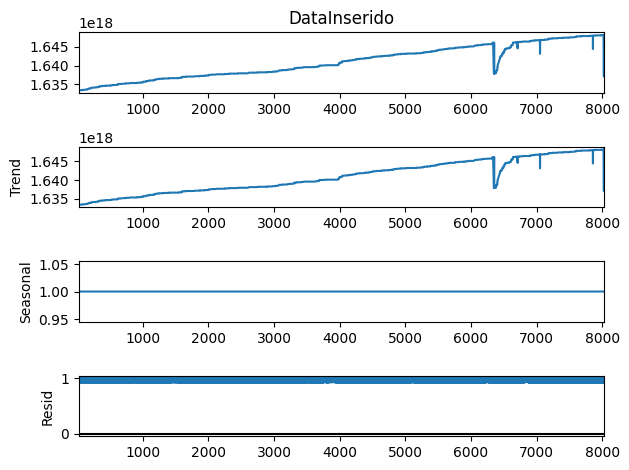

In [226]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(x=new_data['DataInserido'], model='additive', extrapolate_trend='freq', period=1)
result_add.plot()

result_mul = seasonal_decompose(x = new_data['DataInserido'],model = 'mul',extrapolate_trend='freq', period=1)
result_mul.plot();


In [227]:
#Modelos EWMA - Média Móvel Ponderada Exponencial

<AxesSubplot: >

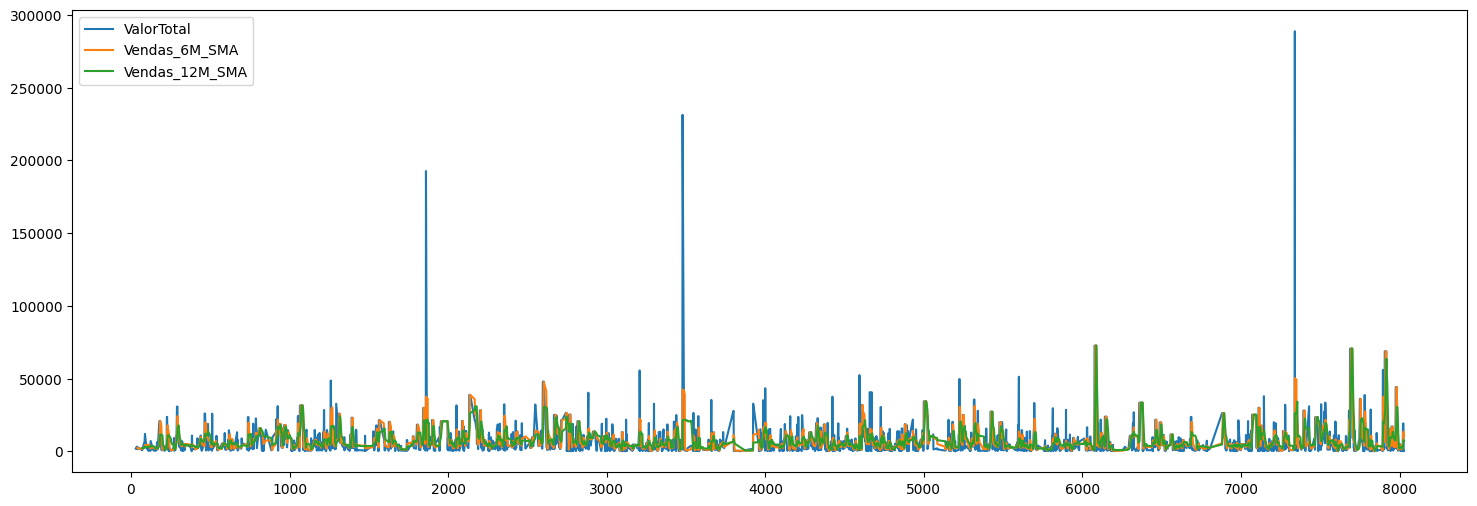

In [228]:
new_data['Vendas_6M_SMA'] = new_data['ValorTotal'].rolling(window=6).mean() 
new_data['Vendas_12M_SMA'] = new_data['ValorTotal'].rolling(window=12).mean() 
new_data[ ['ValorTotal','Vendas_6M_SMA','Vendas_12M_SMA']].plot(figsize=(18,6))

In [229]:
#modelo EWMA Média Móvel Ponderada Exponencial

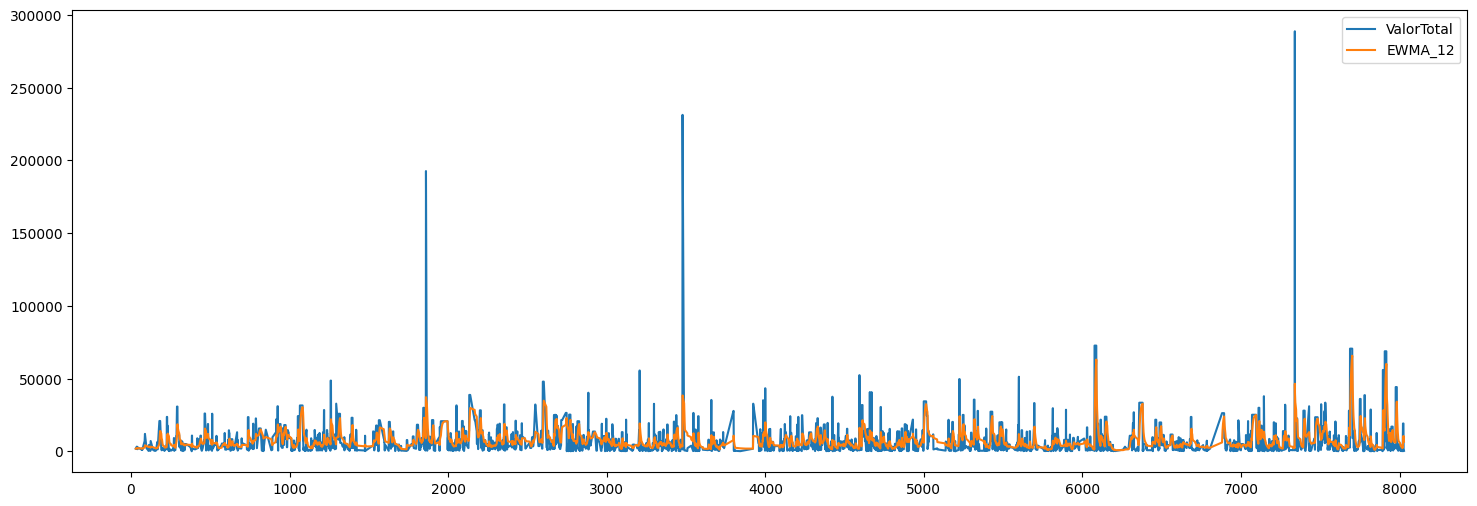

In [230]:
new_data['EWMA_12'] = new_data['ValorTotal'].ewm(span=12,adjust=False).mean() 
new_data[['ValorTotal','EWMA_12']].plot(figsize = (18,6) );

In [231]:
#DES e TES 
#TES Triple Exponential Smoothing | Double Exponential Smoothing

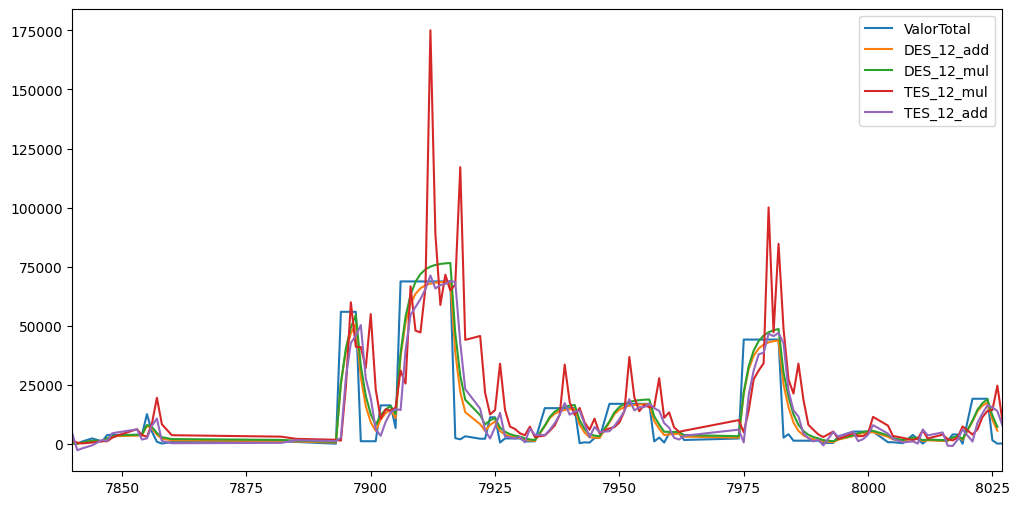

In [232]:
#Setting the index frequency directly to monthly start, thus statsmodels does not need to infer it.
new_data.index.freq = 'MS'
from statsmodels.tsa.holtwinters import ExponentialSmoothing
new_data['DES_12_add'] = ExponentialSmoothing(new_data['ValorTotal'],trend='add').fit().fittedvalues.shift(-1)
new_data['DES_12_mul'] = ExponentialSmoothing(new_data['ValorTotal'],trend='mul').fit().fittedvalues.shift(-1)
new_data['TES_12_add'] = ExponentialSmoothing(new_data['ValorTotal'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
new_data['TES_12_mul'] = ExponentialSmoothing(new_data['ValorTotal'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
new_data[['ValorTotal','DES_12_add','DES_12_mul','TES_12_mul','TES_12_add']].iloc[-128:].plot(figsize=(12,6)).autoscale(axis='x',tight=True)

In [233]:
from pmdarima import auto_arima

In [234]:
auto_arima(new_data['ValorTotal'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4529
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -48041.438
Date:                Fri, 09 Dec 2022   AIC                          96094.877
Time:                        06:53:23   BIC                          96133.386
Sample:                             0   HQIC                         96108.442
                               - 4529                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2578.7938   1105.908      2.332      0.020     411.254    4746.333
ar.L1          0.2336      0.624      0.374      0.708      -0.989       1.457
ar.L2          0.4648      0.497      0.936      0.349      -0.509       1.438
ma.L1          0.2055      0.624      0.329      0.742      -1.018       1.429
ma.L2         -0.2278      0.222     -1.028      0.304      -0.662       0.206
sigma2      9.584e+07      0.861   1.11e+08      0.000    9.58e+07    9.58e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):          13132733.23
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                             9.38
Prob(H) (two-sided):                  0.00   Kurtosis:                       266.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.3e+21. Standard errors may be unstable.
"""

In [ ]:
#Covariância
"""
covariância mede a variância de duas variáveis ​​relacionadas entre si.Quando a covariância é positiva, isso significa
que as duas variáveis ​​estão mudando na mesma direção e podem estar relacionadas. Ao calcular a covariância com a própria
variável, o resultado será então a variância dessa variável
,um caso especial de covariância.
"""

In [ ]:
#Correlação
"""

Função da covariância entre X e Y (denotado por cov(X,Y) ), bem como o desvio padrão de duas variáveis
, respectivamente (denotado pelo operador sigma). Vale a pena notar que o valor da correlação é limitado entre -1 e 1 .
Tomando um exemplo extremo onde X,Y tem exatamente a mesma distribuição, então o numerador se tornaria a fórmula para 
cálculo de variância para X(ou Y)
,que retorna o mesmo valor que o denominador.

"""

In [237]:
#Estacionaridade

In [238]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [239]:
df_train = new_data[:-12]
df_test = new_data[-12:]
model = SARIMAX(df_train['ValorTotal'],order=(3,1,0),seasonal_order=(1,1,1,12))

result = model.fit()
start=len(df_train)
end=len(df_train)+len(df_test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(3,1,0)(1,1,1,12) Predictions')
predictions

4517    4144.654295
4518    1880.470706
4519     459.237016
4520     408.555321
4521    2827.776431
4522     963.065238
4523    1018.902986
4524     813.331789
4525     742.699264
4526   -1036.188748
4527    1626.564718
4528    2336.406621
Name: SARIMA(3,1,0)(1,1,1,12) Predictions, dtype: float64

[Text(0, 0.5, 'Valores Venda')]

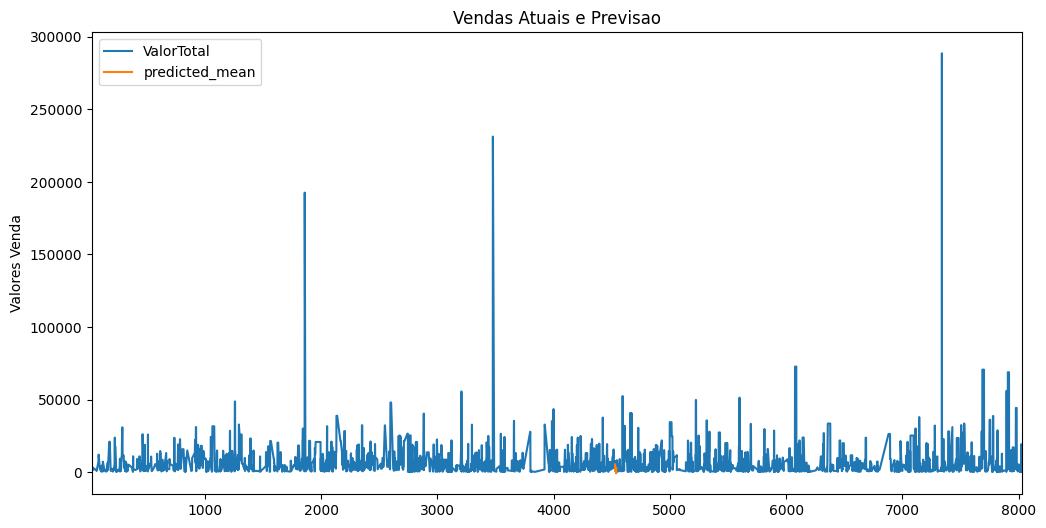

In [240]:
full_model = SARIMAX(new_data['ValorTotal'],order=(3,1,0),seasonal_order=(1,1,1,12))
res2 = full_model.fit()
forecast = res2.predict(len(new_data),len(new_data)+11,typ='levels',rename='Previsão do Modelo SARIMA')
ax = new_data['ValorTotal'].plot(legend = True, figsize=(12,6), title = 'Vendas Atuais e Previsao')
forecast.plot(legend = True)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel = 'Valores Venda')

In [252]:
venda_marca_mes = new_data.groupby(['Marca'])['ValorTotal'].sum().reset_index()
venda_marca_mes

,Marca,ValorTotal
0,Akafloor,58798.69
1,Atlas,1550865.50
2,Belgotex,101973.65
3,Bobinex,915.58
4,Casual Light,940209.44
5,Celite,183022.84
6,Deca,4060599.56
7,Deca Louças,2253202.16
8,Docol Louças,137141.40
9,Docol Metais,965033.57


In [255]:
order_tot = venda_marca_mes.query("Marca == 'Tramontina'")
order_tot


,Marca,ValorTotal
48,Tramontina,800207.0


In [266]:
cancelados = data.query("StatusPedido == 'Cancelado'")
cancelados['StatusPedido'].value_counts()

Cancelado    3477
Name: StatusPedido, dtype: int64

In [267]:
cancelados_tramontia = cancelados.query("Marca == 'Tramontina'")
cancelados_tramontia = cancelados_tramontia['StatusPedido'].value_counts()
cancelados_tramontia


Cancelado    34
Name: StatusPedido, dtype: int64